In this file, we will use **YouTube** trending videos dataset to train a model for text generation language using machine learning, which will be used for the task of title generator for youtube videos or even for our blogs.

**Title generator** is a natural language processing task and is a central issue for several machine learning, including 
* text synthesis, 
* speech to text, and 
* conversational systems. 

To build a model for title generator or a text generator, the model should be trained to learn the probability of a word occurring, using words that have already appeared in the sequence as context.

In [1]:
import pandas as pd
import string
import numpy as np
import json

In [23]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils.np_utils as ku
import tensorflow as tf

In [3]:
tf.random.set_seed(2)
from numpy.random import seed
seed(1)

In [4]:
#load all the datasets 
df1 = pd.read_csv('Data/USvideos.csv')
df2 = pd.read_csv('Data/CAvideos.csv')
df3 = pd.read_csv('Data/GBvideos.csv')

In [5]:
#load the datasets containing the category names
data1 = json.load(open('Data/US_category_id.json'))
data2 = json.load(open('Data/CA_category_id.json'))
data3 = json.load(open('Data/GB_category_id.json'))

We need to process our data to train our machine learning model for title generator. Here are all the data cleaning and processing steps that we need to follow:

In [6]:
def category_extractor(data):
    i_d = [data['items'][i]['id'] for i in range(len(data['items']))]
    title = [data['items'][i]['snippet']["title"] for i in range(len(data['items']))]
    i_d = list(map(int, i_d))
    category = zip(i_d, title)
    category = dict(category)
    return category

In [7]:
#create a new category column by mapping the category names to their id
df1['category_title'] = df1['category_id'].map(category_extractor(data1))
df2['category_title'] = df2['category_id'].map(category_extractor(data2))
df3['category_title'] = df3['category_id'].map(category_extractor(data3))

In [8]:
#join the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

#drop rows based on duplicate videos
df = df.drop_duplicates('video_id')

#collect only titles of entertainment videos
#feel free to use any category of video that we want
entertainment = df[df['category_title'] == 'Entertainment']['title']
entertainment = entertainment.tolist()

In [9]:
#remove punctuations and convert text to lowercase
def clean_text(text):
    text = ''.join(e for e in text if e not in string.punctuation).lower()
    
    text = text.encode('utf8').decode('ascii', 'ignore')
    return text

In [10]:
corpus = [clean_text(e) for e in entertainment]

### Generating Sequences

Natural language processing tasks require input data in the form of a sequence of tokens. The first step after data cleansing is to generate a sequence of `n-gram` tokens.

An **n-gram** is an adjacent sequence of `n` elements of a given sample of text or vocal corpus. Elements can be 
* words, 
* syllables, 
* phonemes, 
* letters, or 
* base pairs. 

In this case, the **n-grams** are a sequence of words in a corpus of titles. Tokenization is the process of extracting tokens from the corpus:

In [11]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    #get tokens
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    #convert to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    return input_sequences, total_words

In [12]:
inp_sequences, total_words = get_sequence_of_tokens(corpus)

### Padding the sequences

Since the sequences can be of variable length, the sequence lengths must be equal. When using neural networks, we usually feed an input into the network while waiting for output. In practice, it is more efficient to process data in batches rather than one at a time.

This is done by using matrices `[batch size x sequence length]`, where the length of the sequence corresponds to the longest sequence. 

In this case, we fill the sequences with a token (usually `0`) to fit the size of the matrix. This process of filling sequences with tokens is called **filling**. To enter the data into a training model, we need to create predictors and labels.

We will create sequences of **n-gram** as predictors and the following word of **n-gram** as label:

In [24]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,  maxlen=max_sequence_len, padding="pre"))
    predictors, label = input_sequences[:,:-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes = total_words)
    return predictors, label, max_sequence_len

In [25]:
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

### LSTM Model

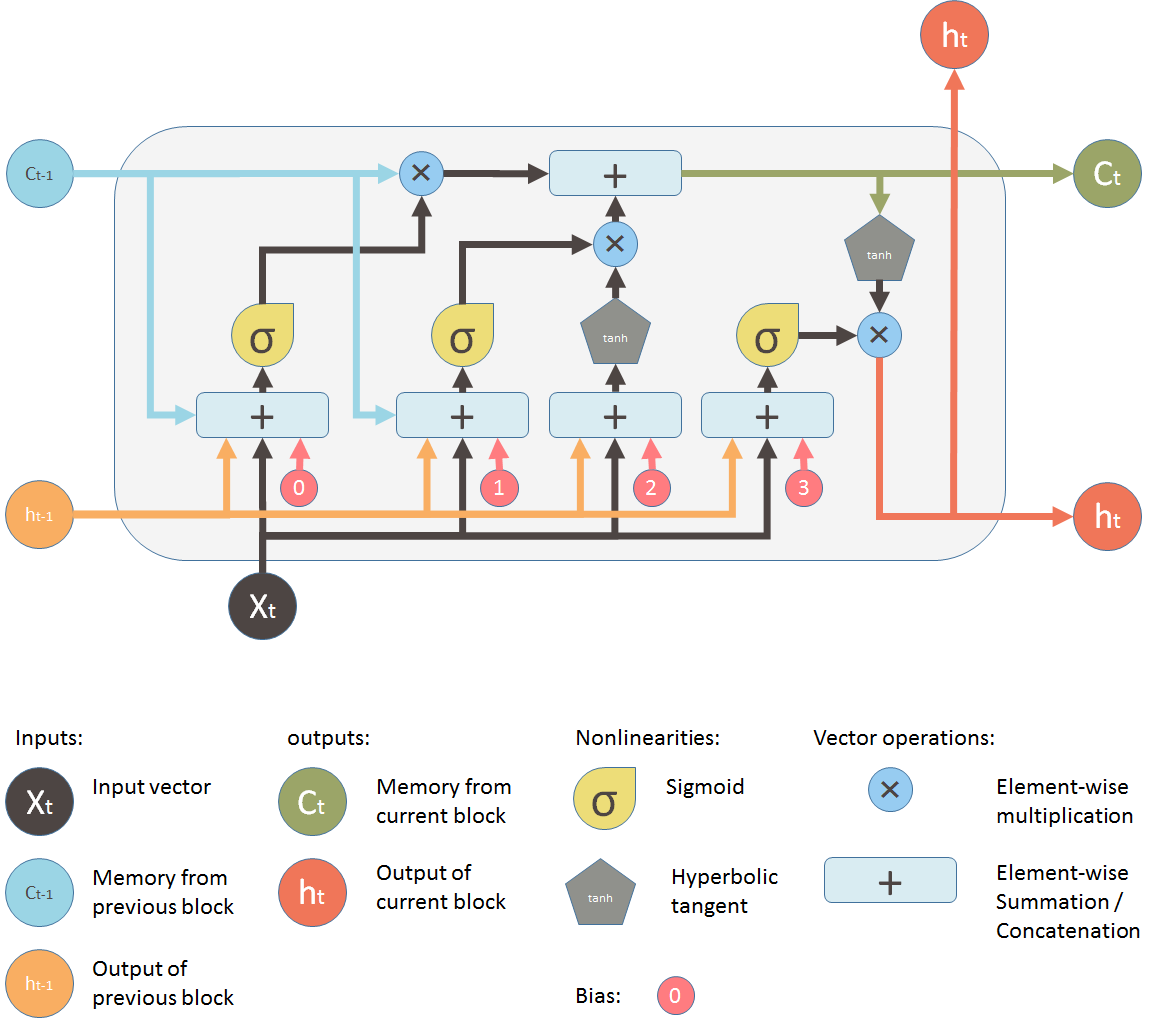

In recurrent neural networks, the activation outputs are propagated in both directions, i.e. from input to output and outputs to inputs, unlike direct-acting neural networks where outputs activation are propagated in only one direction. This creates loops in the architecture of the neural network which acts as a **memory state** of neurons.

As a result, the RNN preserves a state through the stages of time or **remembers** what has been learned over time. The state of memory has its advantages, but it also has its disadvantages. The gradient that disappears is one of them.

In this problem, while learning with a large number of layers, it becomes really difficult for the network to learn and adjust the parameters of the previous layers. To solve this problem, a new type of RNN has been developed; **LSTM (long Short-term memory)**.

### Title Generator with LSTM Model

The LSTM model contains an additional state (the state of the cell) which essentially allows the network to learn what to store in the long term state, what to delete and what to read. The LSTM of this model contains three layers:

* `Input layer`: takes the sequence of words as input
* `LSTM Layer`: Calculates the output using LSTM units.
* `Dropout layer`: a regularization layer to avoid overfitting
* `Output layer`: calculates the probability of the next possible word on output

Now we will use LSTM Model to build model for Title Generator:

In [26]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()

    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))

    # Add Hidden Layer 1 — LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))

    # Add Output Layer
    model.add(Dense(total_words, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam")

    return model

In [27]:
model = create_model(max_sequence_len, total_words)
model.fit(predictors, label, epochs=20, verbose=5)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


### Testing The Model

Our model for title generator is ready and has been trained using the data. It’s time to predict a headline based on the input word. The input word is first tokenized, the sequence is then completed before being passed into the trained model to return the predicted sequence:

In [54]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1) # or model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [58]:
# Generating Titles:

generate_text("spiderman", 5, model, max_sequence_len)

'Spiderman Of The Spiderverse Official Trailer'

In [60]:
print (generate_text("", 5, model, max_sequence_len))
print (generate_text("euclidean", 4, model, max_sequence_len))
print (generate_text("generative", 5, model, max_sequence_len))
print (generate_text("ground breaking", 5, model, max_sequence_len))
print (generate_text("new", 4, model, max_sequence_len))
print (generate_text("understanding", 5, model, max_sequence_len))
print (generate_text("long short term memory", 6, model, max_sequence_len))
print (generate_text("LSTM", 6, model, max_sequence_len))
print (generate_text("a", 5, model, max_sequence_len))
print (generate_text("anomaly", 5, model, max_sequence_len))
print (generate_text("data", 7, model, max_sequence_len))
print (generate_text("designing", 7, model, max_sequence_len))
print (generate_text("reinforcement", 7, model, max_sequence_len))

 Studios The Little House Season
Euclidean Studios The Little House
Generative Studios The Little House Season
Ground Breaking News Trump 122717 Trump Administration
New Eritrean Drama 2018 Nabrana
Understanding Studios The Little House Season
Long Short Term Memory By Magus Responds To New Years
Lstm Studios The Little House Season 2
A Womans Is Divided You You
Anomaly Studios The Little House Season
Data Juice De Iibigin De Monde En Monde
Designing Studios The Little House Season 2 Official
Reinforcement Studios The Little House Season 2 Official
